In [1]:
import torch
import os
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from cnn_model import NNFieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 100
n_steps = 50
step_size = 0.1
n_iterations = 512

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 512/512 [00:10<00:00, 47.41it/s]


>>> Simulation completed
>>> Mean plaq:  0.8939193980768323
>>> Std plaq:  0.00880351098197685


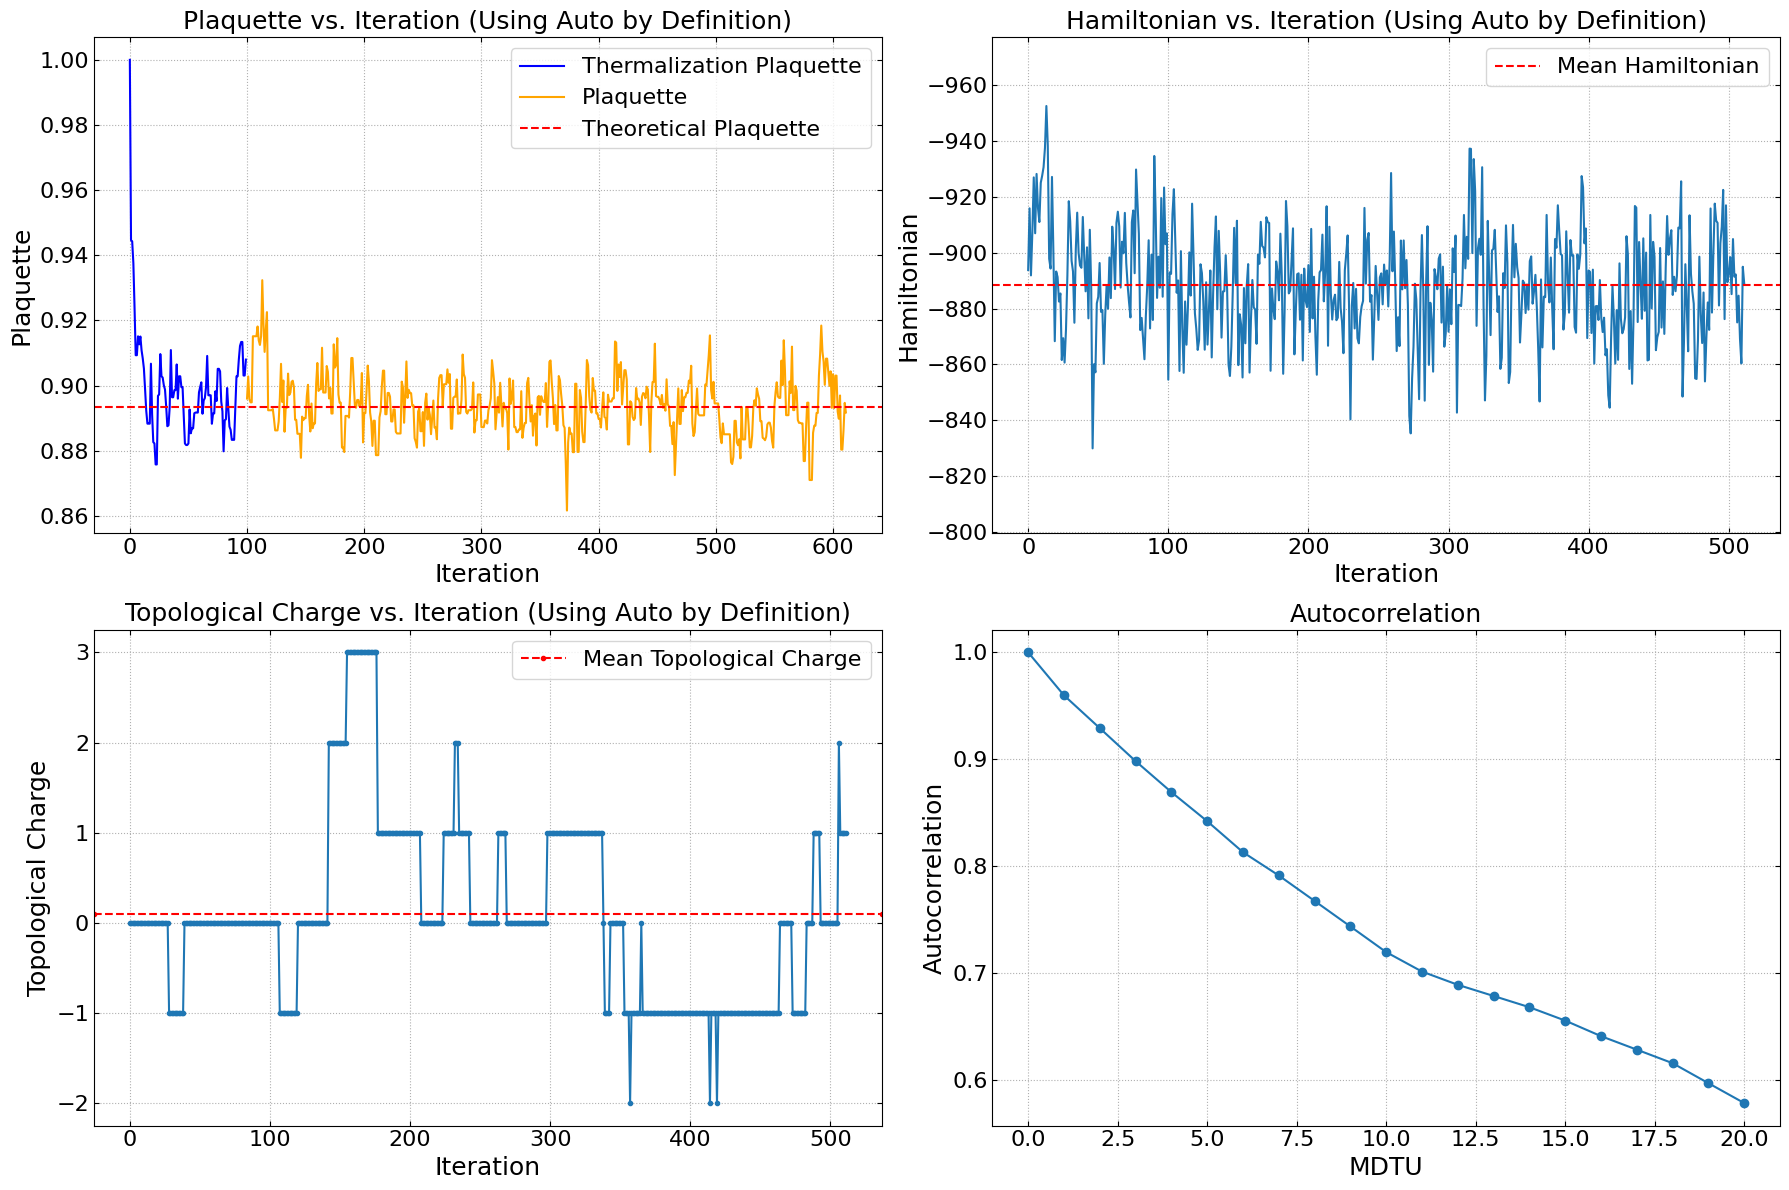

>>> Mean plaq:  0.8939193980768323
>>> Std plaq:  0.00880351098197685


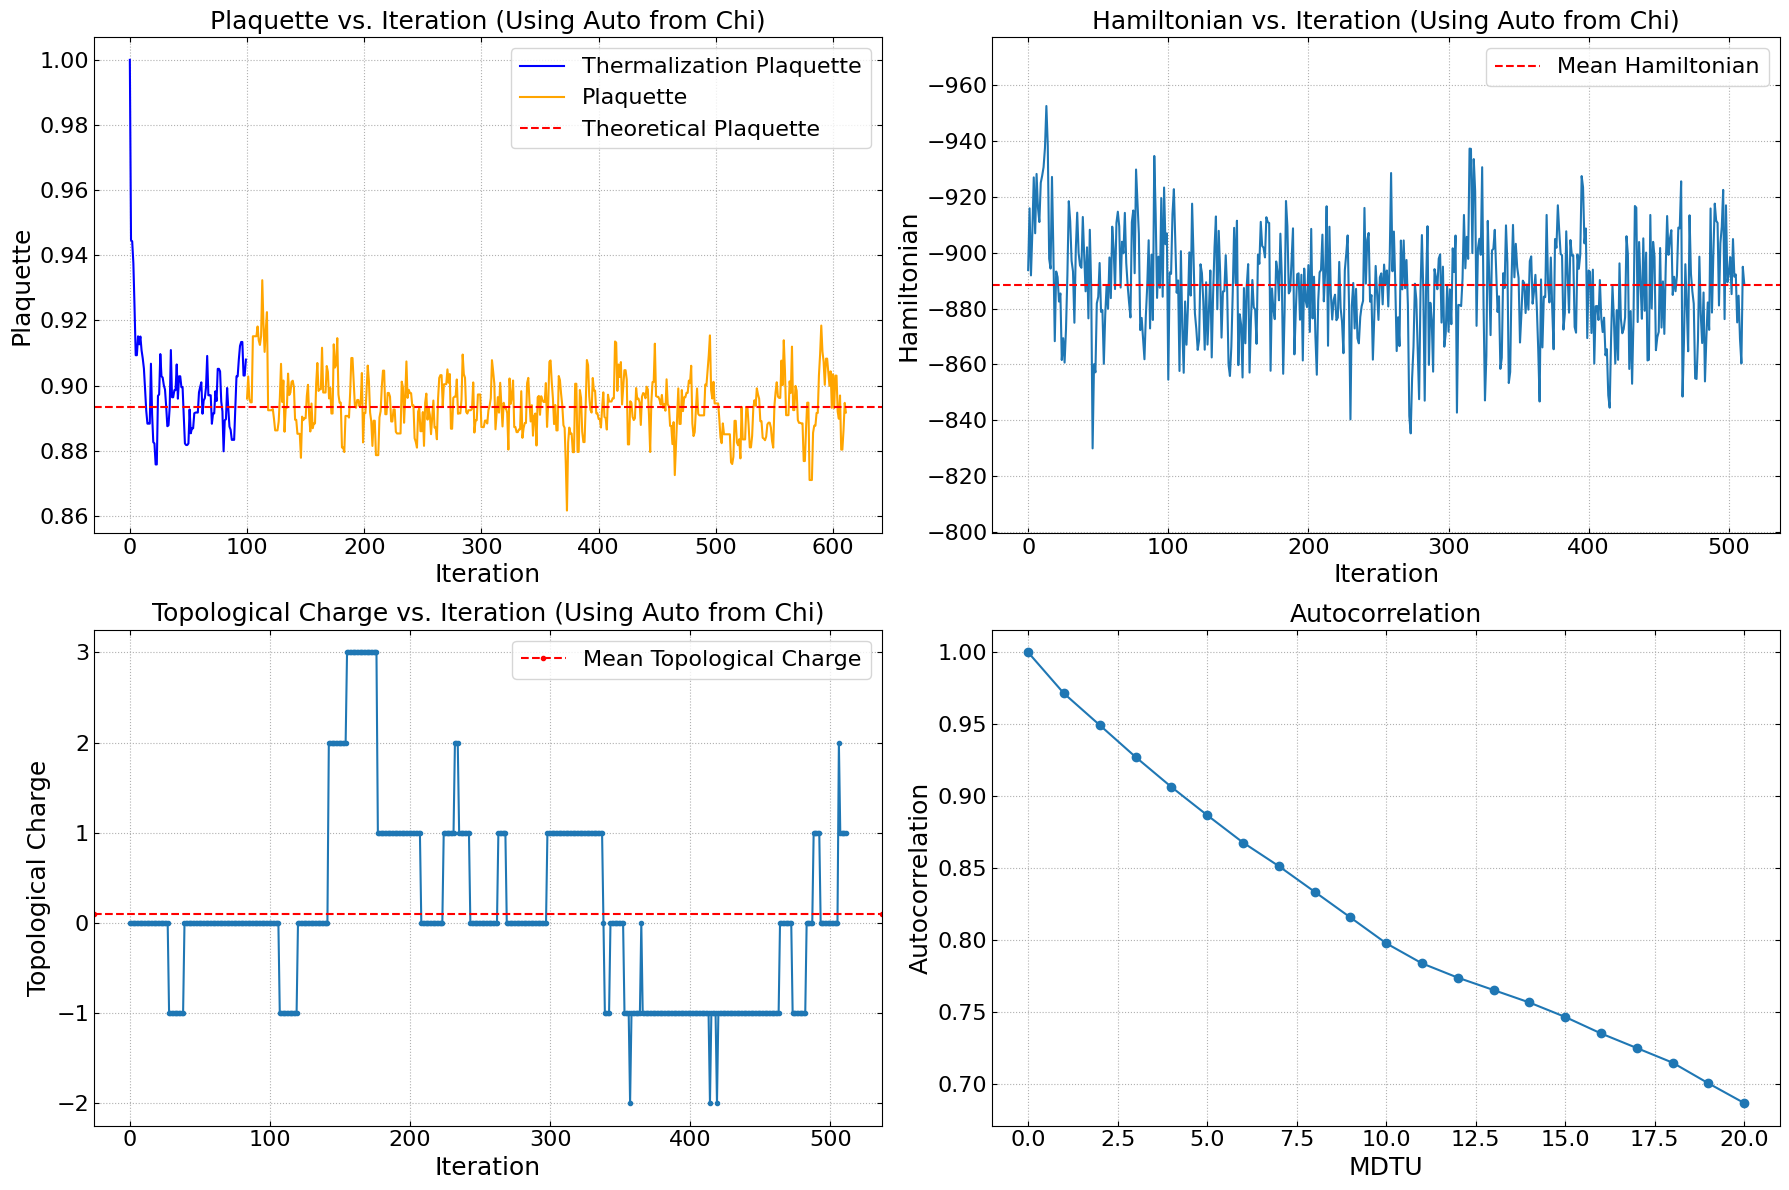

Thermalization acceptance rate: 0.8100
Acceptance rate: 0.7812


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


Training Neural Network:   0%|          | 0/100 [00:00<?, ?it/s]

Training Neural Network:  47%|████▋     | 47/100 [00:02<00:02, 22.80it/s]

Epoch 00052: reducing learning rate of group 0 to 5.0000e-04.


Training Neural Network:  75%|███████▌  | 75/100 [00:03<00:00, 32.71it/s]

Epoch 00061: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00070: reducing learning rate of group 0 to 1.2500e-04.


Training Neural Network: 100%|██████████| 100/100 [00:03<00:00, 25.79it/s]


Epoch 00086: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00092: reducing learning rate of group 0 to 3.1250e-05.
Epoch 00098: reducing learning rate of group 0 to 1.5625e-05.


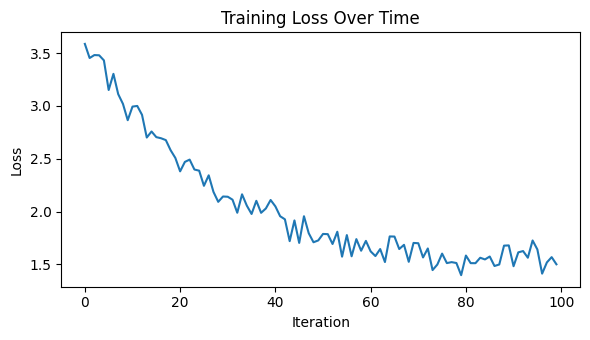

Running HMC: 100%|██████████| 512/512 [05:06<00:00,  1.67it/s] 


>>> Simulation completed
>>> Mean plaq:  0.8849906089017168
>>> Std plaq:  0.010431995915987235


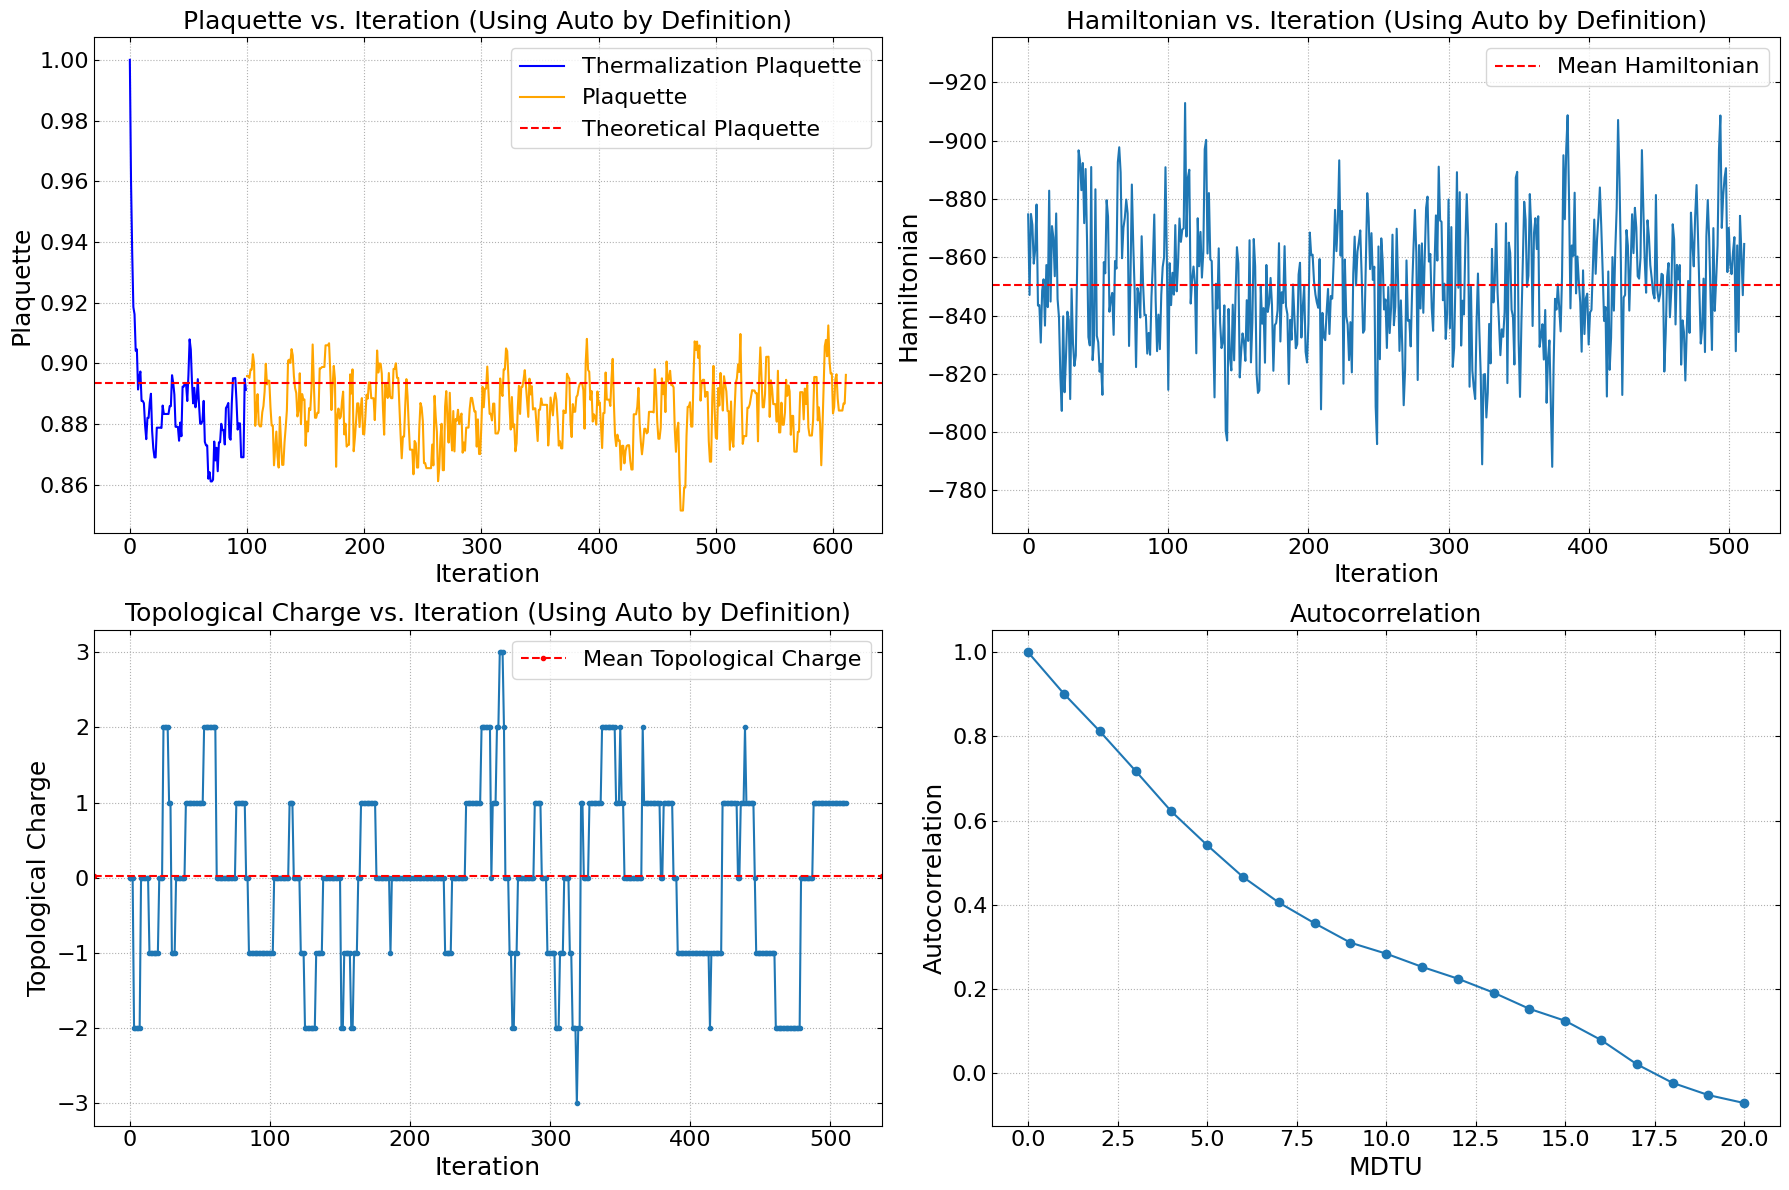

>>> Mean plaq:  0.8849906089017168
>>> Std plaq:  0.010431995915987235


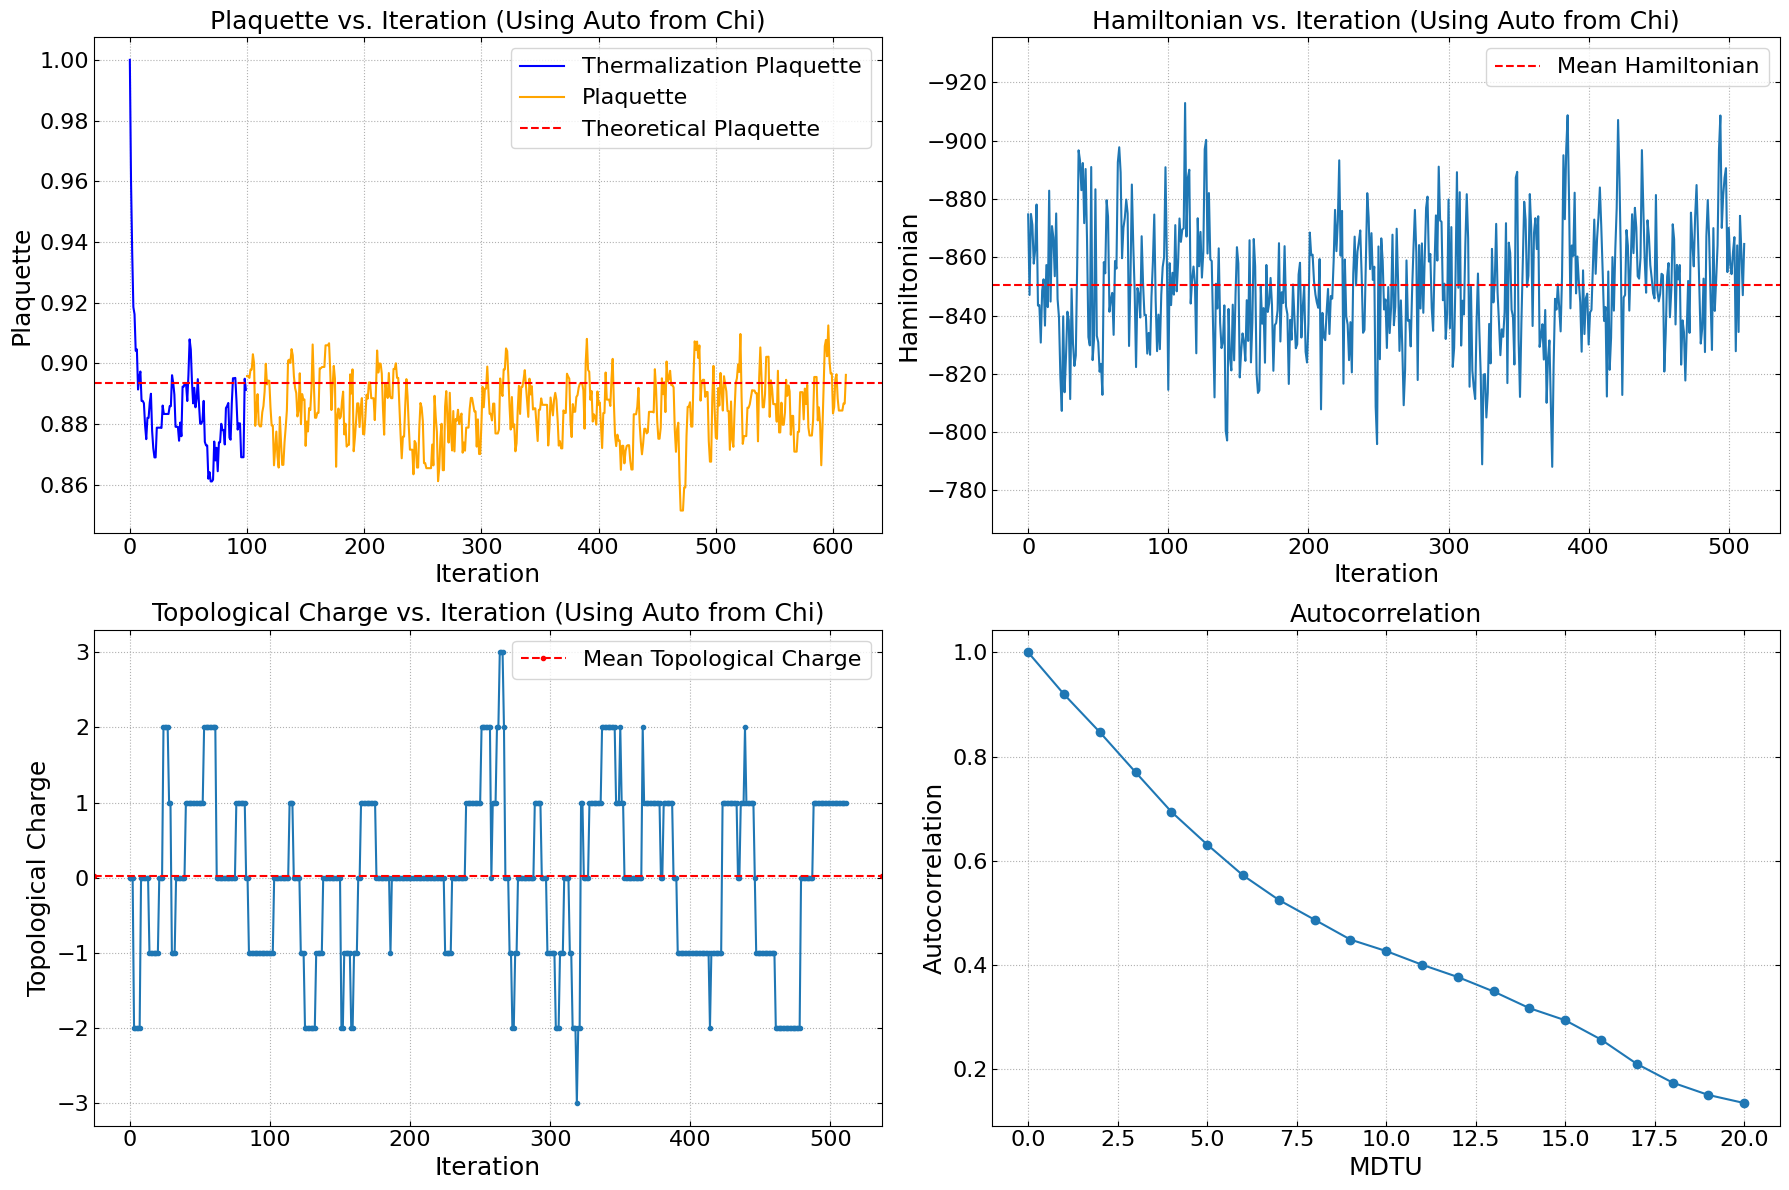

Thermalization acceptance rate: 0.7700
Acceptance rate: 0.7988


In [4]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, epsilon=0.1, jacobian_interval=20, device=device)
nn_transformation.train(beta, n_epochs=100)

# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)